In [2]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.cross_validation import LabelKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
import matplotlib.pyplot as plt
from FeatureExtractor import feature_sets
from FeatureExtractor import util
import itertools

# models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RandomizedLogisticRegression

from FeatureExtractor.fraser_feature_set import get_top_50
from FeatureExtractor.domain_adaptation import expand_feature_space
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

# ====================
import warnings
warnings.filterwarnings('ignore')

In [15]:
# ====================
# globals
REGULARIZATION_CONSTANT = 1

# ------------------
# Diagnosis keys
# - Control
# - MCI
# - Memory
# - Other
# - PossibleAD
# - ProbableAD
# - Vascular
# ------------------

ALZHEIMERS     = ["PossibleAD", "ProbableAD"]
CONTROL        = ['Control']
NON_ALZHEIMERS = ["MCI", "Memory", "Other", "Vascular"]

# ======================
# setup mysql connection
# ----------------------
USER   = 'dementia'
PASSWD = 'Dementia123!'
DB     = 'dementia'
# url = 'mysql://%s:%s@127.0.0.1/%s' % (USER, PASSWD, DB) 
url = 'mysql://%s:%s@localhost/%s' % (USER, PASSWD, DB) 
engine = create_engine(url)
cnx = engine.connect()
# ======================

# ------------------
# Helper functions
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    

def get_top_pearson_features(X,y,n):
    df = pd.DataFrame(X).apply(pd.to_numeric)
    df['y'] = y
    corr_coeff = df.corr()['y'].abs().sort(inplace=False, ascending=False)
    return corr_coeff.index.values[1:n+1].astype(int)

def make_polynomial_terms(df,keep_linear = True):
    cols = df.columns.drop('interview', errors='ignore')
    df = df.apply(pd.to_numeric, errors='ignore')
    # Squared terms 
    for f in cols:
        df["sqr_" + f] = df[f]**2
    #interaction
    for f1 in cols:
        for f2 in cols:
            if f1 != f2:
                df["intr_" + f1 + "_" + f2] = df[f1]*df[f2]
    if not keep_linear:
        df = df.drop(cols, axis=1, errors='ignore')
    return df

def get_data(spacial_db, diagnosis=ALZHEIMERS+CONTROL, include_features=None, exclude_features=None):
    # Read from sql
    lexical    = pd.read_sql_table("dbank_lexical", cnx)
    acoustic   = pd.read_sql_table("dbank_acoustic", cnx)
    diag       = pd.read_sql_table("diagnosis", cnx)
    demo       = pd.read_sql_table("demographic_imputed", cnx)
    discourse  = pd.read_sql_table("dbank_discourse", cnx)
    infounits  = pd.read_sql_table("dbank_cookie_theft_info_units", cnx)
    spacial     = pd.read_sql_table(spacial_db, cnx)
    
    # Merge lexical and acoustic 
    fv = pd.merge(lexical, acoustic, on=['interview'])

    # Add diagnosis
    diag = diag[diag['diagnosis'].isin(diagnosis)]
    fv = pd.merge(fv,diag)
    
    # Add demographics
    fv = pd.merge(fv,demo)
    
    # Add discourse
    fv = pd.merge(fv,discourse, on=['interview'])

    # Add infounits
    fv = pd.merge(fv,infounits, on=['interview'])

    # Add spacial
    # (Add Polynomial)
#     spacial = spacial.drop(exclude_features, errors='ignore')
#     spacial = make_polynomial_terms(spacial)
    fv = pd.merge(fv,spacial, on=['interview'])

    # Randomize
    fv = fv.sample(frac=1,random_state=20)

    # Collect Labels 
    labels = [label[:3] for label in fv['interview']]
    # Split 
    y = fv['dementia'].astype('bool')
    
    # Clean 
    drop = ['dementia', 'level_0', 'interview', 'diagnosis', 'gender', 'index','gender_int']
    if exclude_features:
        drop += exclude_features
    X = fv.drop(drop, 1, errors='ignore')

    X = X.apply(pd.to_numeric, errors='ignore')

    if include_features:
        X = X[include_features]

    return X, y, labels

In [16]:
gen_keyword_features  = feature_sets.get_general_keyword_features()
switches = ["count_ls_rs_switches"]
ratio = ["ratio_left_to_right_keyword_count","ratio_left_to_right_keyword_to_word","ratio_left_to_right_keyword_type_to_token","ratio_left_to_right_keyword_percentage"]
to_exclude = gen_keyword_features + ratio + switches
X_halves, y_halves, labels_halves = get_data(spacial_db="dbank_spatial_halves", exclude_features=to_exclude)

In [27]:
ls_corr = X_halves.corr()['prcnt_ls_uttered'].sort(inplace=False)
rs_corr = X_halves.corr()['prcnt_rs_uttered'].sort(inplace=False)

0.35953840841318635

In [28]:
rs_corr

getSUBTLWordScores           -0.317585
discourse_type_token_ratio   -0.304198
mfcc8_kurtosis               -0.264125
tree_height                  -0.261809
NumAdverbs                   -0.250403
mfcc4_kurtosis               -0.229182
NP_to_PRP                    -0.223219
mfcc7_kurtosis               -0.223058
MeanLengthOfSentence         -0.222927
getLightVerbCount            -0.212427
mfcc5_kurtosis               -0.211116
mfcc1_skewness               -0.198742
mfcc11_kurtosis              -0.195161
RatioPronoun                 -0.192274
INTJ                         -0.186375
ADVP                         -0.184034
mfcc10_kurtosis              -0.180110
mfcc6_kurtosis               -0.179135
INTJ_to_UH                   -0.178691
ls_kw_to_w_ratio             -0.176941
VP                           -0.176043
BrunetIndex                  -0.174587
mfcc9_kurtosis               -0.173321
mfcc3_kurtosis               -0.169288
mfcc13_kurtosis              -0.143326
ls_ty_to_tok_ratio       

In [13]:
# X_halves.plot(x='MeanWordLength', y = 'ls_count', kind='scatter')
# X_halves.plot(x='MeanWordLength', y = 'rs_count', kind='scatter')

# X_halves.plot(x='MeanWordLength', y = 'ls_kw_to_w_ratio', kind='scatter')
# X_halves.plot(x='MeanWordLength', y = 'rs_kw_to_w_ratio', kind='scatter')

# X_halves.plot(x='MeanWordLength', y = 'ls_ty_to_tok_ratio', kind='scatter')
# X_halves.plot(x='MeanWordLength', y = 'rs_ty_to_tok_ratio', kind='scatter')

# X_halves.plot(x='MeanWordLength', y = 'prcnt_ls_uttered', kind='scatter')
# X_halves.plot(x='MeanWordLength', y = 'prcnt_rs_uttered', kind='scatter')

corr(percent_ls, concretenessScore) = 0.527843
corr(percent_rs, concretenessScore) = 0.359538


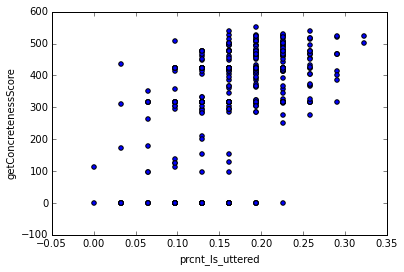

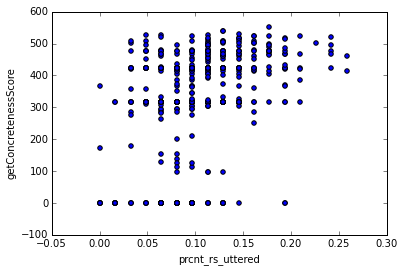

In [37]:
X_halves.plot(x = 'prcnt_ls_uttered', y='getConcretenessScore', kind='scatter')
X_halves.plot(x = 'prcnt_rs_uttered', y='getConcretenessScore', kind='scatter')
print "corr(percent_ls, concretenessScore) = %f" % ls_corr.loc['getConcretenessScore']
print "corr(percent_rs, concretenessScore) = %f" % rs_corr.loc['getConcretenessScore']

corr(percent_ls, MeanWordLength) = 0.223760
corr(percent_rs, MeanWordLength) = 0.336916


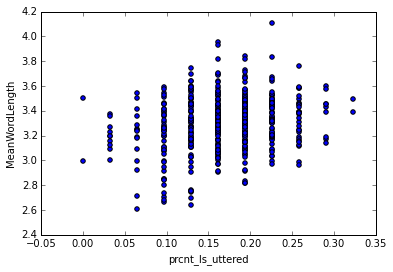

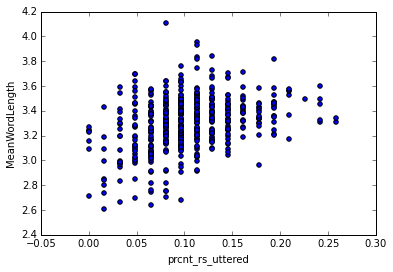

In [38]:
X_halves.plot(x = 'prcnt_ls_uttered', y='MeanWordLength', kind='scatter')
X_halves.plot(x = 'prcnt_rs_uttered', y='MeanWordLength', kind='scatter')
print "corr(percent_ls, MeanWordLength) = %f" % ls_corr.loc['MeanWordLength']
print "corr(percent_rs, MeanWordLength) = %f" % rs_corr.loc['MeanWordLength']

In [9]:
model_fs = RandomizedLogisticRegression(C=1)
scores      = []
feat_number = []
for train_index, test_index in label_kfold:
    # Split
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    indices = get_top_pearson_features(X_train, y_train, 100)

#     # Select k features 
#     X_train = X_train[:,indices]
#     X_test  = X_test[:,indices]

    model_fs = model_fs.fit(X_train, y_train)
#     print model_fs.scores_
#     print X.columns[model_fs.get_support()]
#     print model_fs.scores_[model_fs.get_support(indices=True)]

    X_train = model_fs.transform(X_train)
    X_test  = model_fs.transform(X_test)

    feat_number.append(X_train.shape[1])

    model.fit(X_train, y_train)
    yhat  = model.predict(X_test)              
    scores.append(accuracy_score(y_test, yhat))
    import pdb; pdb.set_trace()
    print "randomizedLR"
    for f in sorted(zip(map(lambda x: round(x, 4), model_fs.scores_), X.columns), reverse=True):
        print f

    print "Pearson"
    for f in X.columns[indices]:
        print f
    
    

print "Avg. features: %f" % np.mean(feat_number)
print np.mean(scores)


> <ipython-input-9-9ed60eaf02e5>(29)<module>()
-> print "randomizedLR"
(Pdb) model_fs.scores_
array([ 0.175,  0.54 ,  0.   ,  0.   ,  0.   ,  0.225,  0.425,  0.   ,
        0.135,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.035,  0.005,  0.005,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.63 ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.085,  0.545,  0.   ,  0.   ,  0.17 ,  0.   ,  0.005,
        0.38 ,  0.   ,  0.035,  0.145,  0.   ,  0.   ,  0.09 ,  0.03 ,
        0.115,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.22 ,  0.   ,  0.065,  0.01 ,  0.005,  0.   ,  0.   ,  0.   ,
        0.205,  0.12 ,  0.   ,  0.   ,  0.06 ,  0.425,  0.315,  0.   ,
        0.345,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.02 ,  0.065,  0.535,  0.105,  0.02 ,  0.135,  0.   ,  0.41 ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.43 ,  0.49 ,

KeyboardInterrupt: 

In [10]:
model_fs.scores_

array([ 0.175,  0.54 ,  0.   ,  0.   ,  0.   ,  0.225,  0.425,  0.   ,
        0.135,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.035,  0.005,  0.005,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.63 ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.085,  0.545,  0.   ,  0.   ,  0.17 ,  0.   ,  0.005,
        0.38 ,  0.   ,  0.035,  0.145,  0.   ,  0.   ,  0.09 ,  0.03 ,
        0.115,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.22 ,  0.   ,  0.065,  0.01 ,  0.005,  0.   ,  0.   ,  0.   ,
        0.205,  0.12 ,  0.   ,  0.   ,  0.06 ,  0.425,  0.315,  0.   ,
        0.345,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.02 ,  0.065,  0.535,  0.105,  0.02 ,  0.135,  0.   ,  0.41 ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.43 ,  0.49 ,  0.   ,  0.49 ,
        0.305,  0.   ,  0.   ,  0.515,  0.335,  0.   ,  0.02 ,  0.065,
      

In [34]:
f = sorted(zip(X.columns, map(lambda x: round(x, 4), model_fs.scores_)), reverse=True,  key=lambda x: x[1])
df = pd.DataFrame(f)
df

,0,1
0,age,0.925
1,MeanWordLength,0.630
2,NP_to_PRP,0.545
3,ADVP,0.540
4,binaryIUActionStoolFalling,0.535
5,binaryIUSubjectGirl,0.515
6,keywordIUSubjectWoman,0.515
7,binaryIUObjectStool,0.490
8,binaryIUObjectWindow,0.490
9,mfcc5_kurtosis,0.490
